# FUN of AI
 - https://teachablemachine.withgoogle.com/
 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.optim as optim
import torch.nn as nn
from IPython import display


In [2]:
print(torch.__version__)

1.9.0


In [3]:
X1 = np.random.randn(2000,1)
X2 = np.random.randn(2000,1)

# Data has a special pattern such that X3 = - X1 - X2
X_train = np.concatenate([X1, X2, - X1 - X2], axis = 1)

In [4]:
np.random.randn?

In [5]:
X_train.shape

(2000, 3)

In [6]:
X_train[:5]

array([[-0.72238925, -0.38277841,  1.10516766],
       [ 0.02634293,  1.74646448, -1.7728074 ],
       [ 0.36648005,  0.13225013, -0.49873018],
       [ 0.92531238,  0.50426411, -1.42957649],
       [ 1.85745452,  0.86401279, -2.72146731]])

# ANN
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/560px-Colored_neural_network.svg.png)

> ANN = Universal function approximator!!

Supervised learning
  - you have (input , output) pairs
  - you try yo predict output from the input with your ANN





# AutoEncoder

> Watch https://www.youtube.com/watch?v=7mRfwaGGAPg

__Reconstruction Error__ (MSE:Mean Squared Error)

 - $ E = \frac{1}{n}\sum^n_i (X_i - X'_i)^2$
 - $X' = \sigma_d(W_d \sigma_e (W_eX + b_e) + b_d)$

You are looking for best parameters $W_e, b_e, W_d, b_d$ that minimize the Reconstruction Error E.

 - You use a gradient-descent based approach for optimisation


 ## Application for compression
Instead of sending the original data X, we compress our data into smaller dimension (h) in the encoder part of the AutoEncoder. And sent h it to receiver.

Receiver should know the decoder part of the AutoEncoder.
 - $W_d, b_d, \sigma_d$



![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/440px-Autoencoder_schema.png)

Resource
 - https://en.wikipedia.org/wiki/Autoencoder



UnSupervised learning
  - you dont have (input , output) pairs
  - you have only(input, ) data
  - you try to first encode your input to a smaller dimension than you decode it to the original dimension, hence you generate some output with AutoEncoder
  - Your objective is yto generate an output as close as possible to its original input,



In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Input
x_train_tensor = torch.from_numpy(X_train).float()
# Output : X_train and y_train is same
# In autoencoders, output = input
# output y shoul be as close as possible to input X
y_train_tensor = torch.from_numpy(X_train).float()


# Linear Model
learning_rate = 1e-2 # alpha

# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    # -- encoder part ---
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.ReLU(),
    # -- decoder part ---
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    #nn.ReLU()
)

model_compress = nn.Sequential(
    # -- encoder part ---
    nn.Linear(3, 2),
    #nn.ReLU(),
    # -- decoder part ---
    nn.Linear(2, 3),
    #nn.ReLU()
)

class AE(nn.Module):
  def __init__(self, n_features):
    super(AE, self).__init__()
    self.fc1 = nn.Linear(n_features, 2)
    self.fc2 = nn.Linear(2, n_features)

  def encode(self, x):
    return self.fc1(x)

  def decode(self, x):
    return self.fc2(x)

  def forward(self, x):
    h = self.encode(x)
    return self.decode(h)

ae = AE(3)


criterion = nn.MSELoss() # (x-y)^2
optimizer = torch.optim.Adam(ae.parameters(), 
                             lr=learning_rate)
n_epoch = 1000
losses = []
for t in range(n_epoch):
    
    # Feed forward to get the logits
    y_pred = ae(x_train_tensor)
    #y_pred = ae(x_train_tensor)
    
    # Compute the loss 
    loss = criterion(y_pred, y_train_tensor)
    # Dont accumulate previous gradients
    optimizer.zero_grad()

    print(f"[EPOCH]: {t}/{n_epoch}, [LOSS]: {loss.item():.6f}")
    display.clear_output(wait=True)
    losses.append(loss.item())
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params with some gradient-based method
    optimizer.step()

[EPOCH]: 999/1000, [LOSS]: 0.000000


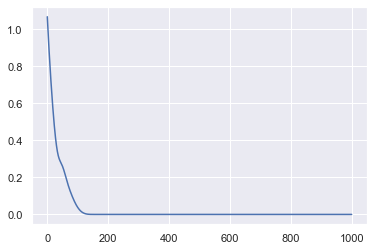

In [29]:
plt.plot(losses)

## Normal data 

with the original pattern

AutoEncoder can succesfully reconstruct data that has the pattern X3 = - X1 - X2. Why?

 - Because the training data had that pattern !! 

In [30]:
# Original data has a pattern such that X3 = - X1 - X2
with torch.no_grad():
  x_test = np.array([[0.1, 0.1, -0.2],
                     [0.15, 0.15, -0.3],
                     [0,  1, -1 ],
                     [-0.4, 0.7, - 0.3 ]])

  x_test_tensor = torch.from_numpy(x_test).float()
  y_test_pred = ae(x_test_tensor)
  h = ae.encode(x_test_tensor)
  print(h)
  xp = ae.decode(h)
  print(xp)


tensor([[-0.0834, -0.0044],
        [-0.0365,  0.1196],
        [ 0.9140,  1.0308],
        [ 0.6475,  0.1674]])
tensor([[ 1.0000e-01,  1.0000e-01, -2.0000e-01],
        [ 1.5000e-01,  1.5000e-01, -3.0000e-01],
        [-3.7253e-09,  1.0000e+00, -1.0000e+00],
        [-4.0000e-01,  7.0000e-01, -3.0000e-01]])


In [31]:
# Original data has a pattern such that X3 = - X1 - X2
with torch.no_grad():
  x_test = np.array([[0.1, 0.5, -0.6],
                     [0.5, 0.5, -1],
                     [0,  1, -1 ],
                     [-0.4, 0.7, - 0.3 ]])

  x_test_tensor = torch.from_numpy(x_test).float()
  y_test_pred = model(x_test_tensor)
  print(y_test_pred)
  print(y_test_pred.sum(axis = 1))

tensor([[ 0.2236,  0.2013, -0.3362],
        [ 0.2088,  0.1705, -0.3236],
        [ 0.2147,  0.1957, -0.3259],
        [ 0.2313,  0.2460, -0.3368]])
tensor([0.0887, 0.0557, 0.0844, 0.1405])


In [36]:
# Original data has a pattern such that X3 = - X1 - X2
with torch.no_grad():
  x_test = np.array([[0.1, 0.5, -0.6]])

  x_test_tensor = torch.from_numpy(x_test).float()
  z = ae.encode(x_test_tensor)
  print('z: ', z)
  xp = ae.decode(z)
  print('xp: ', xp)

z:  tensor([[0.3531, 0.5088]])
xp:  tensor([[ 0.1000,  0.5000, -0.6000]])


## Abnormal data

This data does not have the original pattern 
 - Original data has a pattern such that X3 = - X1 - X2

In [32]:
# Original data has a pattern sucj that X3 = - X1 - X2
with torch.no_grad():
  x_test = np.array([[0.1, 0.5, 0],
                     [0.5, 0.5, 0],
                     [0,  1,    0],
                     [-0.4, 0.7, 0]])

  x_test_tensor = torch.from_numpy(x_test).float()
  y_test_pred = model(x_test_tensor)
  print(y_test_pred)
  print(y_test_pred.sum(axis = 1))

tensor([[ 0.2452,  0.2457, -0.3565],
        [ 0.2429,  0.2331, -0.3583],
        [ 0.2326,  0.2484, -0.3381],
        [ 0.2342,  0.2576, -0.3392]])
tensor([0.1344, 0.1177, 0.1430, 0.1526])


## Anomaly Detection

In [33]:
X1 = np.random.randn(1000,1)
X2 = np.random.randn(1000,1)

# Generate test data with the special pattern X3 = - X1 - X2
# REMEMBER: 
  # This is the pattern that is fed to the AutoEncoder in the training phase
  # At training phase, AutoEncoder succesfully learned to encode and decode that pattern
X_test = np.concatenate([X1, X2, - X1 - X2], axis = 1)

# Inject anomaly: without the pattern such that X3 = - X1 - X2
X_test[:100] = np.random.randn(100,3)

In [34]:
with torch.no_grad():
  x_test_tensor = torch.from_numpy(X_test).float()
  y_test_pred = ae(x_test_tensor)

  reconstruction_error = torch.sum((y_test_pred - x_test_tensor)**2, axis = 1)

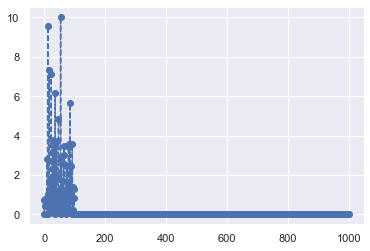

In [35]:
plt.plot(reconstruction_error, '--o')
plt.show()

In [58]:
reconstruction_error[:5]

tensor([6.1841, 5.6386, 0.9548, 3.6897, 0.1735])

In [59]:
reconstruction_error[-5:]

tensor([0.0638, 3.7308, 0.6207, 0.0314, 1.8466])

In [60]:
reconstruction_error.shape

torch.Size([1000])

# Further Experiments

In [18]:
np.zeros(shape = (5,5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [19]:
np.random.randint(low = 100, high = 255, size = 5)

array([144, 214, 206, 234, 241])

In [20]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [21]:
diag = np.random.randint(low = 100, high = 255, size = 5)/255 # normalization 
values = diag * np.eye(5)
values

array([[0.53333333, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.63921569, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.76470588, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.64313725, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.85882353]])

## Pattern of the data
 - All the non-diagonal values are zero
 - And diagonal values are in between [0,1]

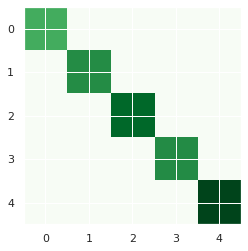

In [22]:
plt.imshow(values, cmap ='Greens')

In [23]:
def generate_data():
  diag = np.random.randint(low = 100, high = 255, size = 5)/255
  values = diag * np.eye(5)
  return values

In [24]:
X = np.array([generate_data() for i in range(1000)])

In [25]:
X.shape

(1000, 5, 5)

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.from_numpy(X).float().view(-1, 25)
# X_train and y_train is same
y_train_tensor = torch.from_numpy(X).float().view(-1, 25)


# Linear Model
learning_rate = 1e-2 # alpha

# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    # -- encoder part ---
    nn.Linear(25, 10), # W1_e 25x10, b1_e 10x1
    nn.ReLU(),
    nn.Linear(10, 3), # W2_e 10x3, b2_e 3x1
    nn.ReLU(),
    # -- decoder part ---
    nn.Linear(3, 10), # W1_d 3x10, b1_d 10x1
    nn.ReLU(),
    nn.Linear(10, 25), # W2_d 10x25, b2_d 25x1
    #nn.ReLU()
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)
n_epoch = 1000
losses = []
for t in range(n_epoch):
    
    # Feed forward to get the logits
    y_pred = model(x_train_tensor)
    
    # Compute the loss 
    loss = criterion(y_pred, y_train_tensor)
    # Dont accumulate previous gradients
    optimizer.zero_grad()

    print(f"[EPOCH]: {t}/{n_epoch}, [LOSS]: {loss.item():.6f}")
    display.clear_output(wait=True)
    losses.append(loss.item())
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params with gradient descent 
    optimizer.step()

[EPOCH]: 999/1000, [LOSS]: 0.004975


[[0.78823529 0.         0.         0.         0.        ]
 [0.         0.98431373 0.         0.         0.        ]
 [0.         0.         0.81568627 0.         0.        ]
 [0.         0.         0.         0.70980392 0.        ]
 [0.         0.         0.         0.         0.92941176]]


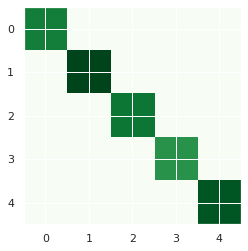

In [27]:
x_test = generate_data()
print(x_test)
plt.imshow(x_test, cmap ='Greens')

tensor([[ 8.1211e-01, -2.1450e-05,  3.7879e-05, -5.4240e-05,  1.6906e-04],
        [-1.7181e-04,  8.8993e-01, -2.2026e-04, -4.6223e-05,  7.9380e-04],
        [-4.9144e-05, -3.4343e-04,  8.1372e-01, -1.2956e-04, -3.7043e-04],
        [-4.3266e-05,  6.7629e-05, -1.2100e-04,  8.7563e-01,  2.5861e-05],
        [ 1.3542e-04,  2.2803e-05, -4.5732e-05, -6.9908e-04,  7.9519e-01]])


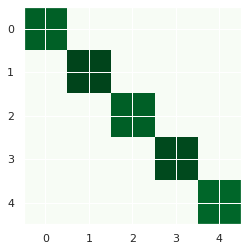

In [28]:
with torch.no_grad():
  x_test_tensor = torch.from_numpy(x_test).float().view(-1,25)
  y_test_pred = model(x_test_tensor).view(5,5)
  print(y_test_pred)
  plt.imshow(y_test_pred, cmap ='Greens')

## Denoising

In [29]:
## Denoising

[[0.55271544 0.02622225 0.05672018 0.04597034 0.07858967]
 [0.07590316 0.92434865 0.05931146 0.02316673 0.01454247]
 [0.03198641 0.02758936 0.7113482  0.03753212 0.04799221]
 [0.05042711 0.02436957 0.07140973 0.86475811 0.04761819]
 [0.08341268 0.00250574 0.05054818 0.03251947 0.99349168]]


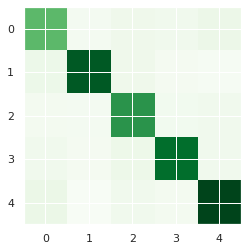

In [30]:
x_test = generate_data() + np.random.rand(5,5)/10
print(x_test)
plt.imshow(x_test, cmap ='Greens')

tensor([[ 7.9846e-01, -1.8731e-05,  3.3133e-05, -4.7777e-05,  1.4859e-04],
        [-1.5085e-04,  8.6740e-01, -1.9448e-04, -4.0565e-05,  6.9782e-04],
        [-4.3519e-05, -3.0203e-04,  7.9907e-01, -1.1345e-04, -3.2516e-04],
        [-3.8244e-05,  5.9083e-05, -1.0680e-04,  8.5431e-01,  2.2888e-05],
        [ 1.1894e-04,  1.9893e-05, -4.0554e-05, -6.1458e-04,  7.8264e-01]])


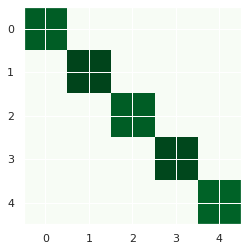

In [31]:
with torch.no_grad():
  x_test_tensor = torch.from_numpy(x_test).float().view(-1,25)
  y_test_pred = model(x_test_tensor).view(5,5)
  print(y_test_pred)
  plt.imshow(y_test_pred, cmap ='Greens')

In [32]:
import pandas as pd

mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv').values

In [33]:
mnist_train.shape

(19999, 785)

5


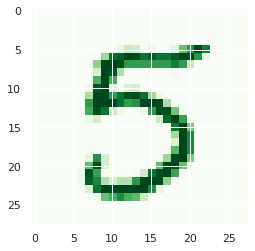

In [34]:
observation0 = mnist_train[0][1:].reshape(28,28) # 784 = 28x28
label0 = mnist_train[0][0] # 1 for label

print(label0)
plt.imshow(observation0, cmap ='Greens')

# Visual code

In [35]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [36]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [37]:
model = nn.Sequential(
    # -- encoder part ---
    nn.Linear(25, 10), # W1_e 25x10, b1_e 10x1
    nn.ReLU(),
    nn.Linear(10, 3), # W2_e 10x3, b2_e 3x1
    nn.ReLU(),
    # -- decoder part ---
    nn.Linear(3, 10), # W1_d 3x10, b1_d 10x1
    nn.ReLU(),
    nn.Linear(10, 25), # W2_d 10x25, b2_d 25x1
    #nn.ReLU()
)

In [38]:
class Net(nn.Module):

  def __init__(self, n_features = 3):
    super(Net, self).__init__()
    # -- encoder part ---
    self.fc1 = nn.Linear(n_features, 4)
    self.fc2 = nn.Linear(4, 1)
     # -- decoder part ---
    self.fc3 = nn.Linear(1, 4)
    self.fc4 = nn.Linear(4, n_features)

  def forward(self, x):
    # -- encoder part ---
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    # -- decoder part ---
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

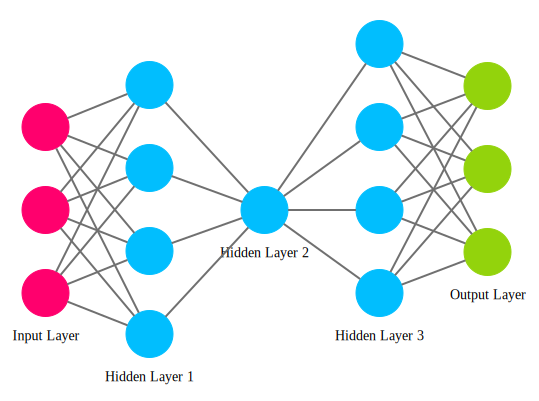

In [39]:
net = Net()
ann_viz(net, view=False)